In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load("en_core_web_lg")
pd.set_option("display.max_rows",None)
nltk.download("vader_lexicon")
nltk.download("punkt")
import re

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\25bak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [144]:
train=pd.read_csv("Data/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [145]:
test=pd.read_csv("Data/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [146]:
print("Null values in training set")
print(train.isnull().sum())
print("Null values in testing set")
print(test.isnull().sum())

Null values in training set
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Null values in testing set
id             0
keyword       26
location    1105
text           0
dtype: int64


In [147]:
print(train[["keyword","text"]].sample(10))

              keyword                                               text
5920         screamed  I heard the steven universe theme song from up...
305        armageddon  #PBBan (Temporary:300) Russaky89 @'aRmageddon ...
5670           rescue  Coastal German Shepherd Rescue OC shared a lin...
3801     fire%20truck  rgj: Truck trailer catches fire in Reno http:/...
4447          hostage  Sydney hostage crisis has now been recovered f...
7113  violent%20storm  Dramatic Video Shows Plane Landing During Viol...
2532       desolation  Emotional Desolation the effect of alcoholism/...
5831           rubble  China's Stock Market Crash: Are There Gems In ...
5187      obliterated                        I'm about to be obliterated
1625         collapse  Growth dries up for BHP Billiton as oil price ...


In [148]:
train_real=train[train["target"]==1]
train_fake=train[train["target"]==0]

In [149]:
print(train_real.shape," is the size of real train dataset")
print(train_fake.shape," is the size of fake train dataset")

(3271, 5)  is the size of real train dataset
(4342, 5)  is the size of fake train dataset


In [150]:
print(train_real["keyword"].nunique(),train_fake["keyword"].nunique())
print(test["keyword"].nunique())
print(set(train.keyword.unique())-set(test.keyword.unique()))

220 218
221
set()


In [151]:
impWords=train["keyword"].unique()[:15]
print(impWords)

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked']


In [152]:
# plt.figure(figsize=(15,10))
# sns.countplot(x=train["keyword"],hue=train["target"])
# plt.xticks(rotation=90)

In [153]:
unique=train["keyword"].unique().astype("str")
unique.tolist()
# uniqueCollection=[unique[i:i+15] 
#                   for i in range(0,len(unique),15)]
# plt.figure(figsize=(10,15))
# subplot_counter=1
# for group in uniqueCollection:
#     plt.figure(figsize=(10,15))
#     plt.subplot(len(uniqueCollection),1,subplot_counter)
#     countplot=sns.countplot(data=train[train["keyword"].isin(group)],x="keyword",hue="target")
#     plt.xticks(rotation=90)
#     plt.legend(title="target",loc="lower left")

['nan',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolat

In [154]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiment=SentimentIntensityAnalyzer()

In [155]:
def lastKeyIn(info):
    keyword=info[0]
    text=info[1]
    if pd.notna(keyword):
         return keyword
    doc=nlp(text)
    high_neg=0
    negative_word=None
    for word in doc:
        if word.is_stop or word.is_oov or word.is_space or word.is_punct:
             pass
        elif word.is_ascii:
            if word.text in unique or word.lemma_ in unique:
                return word
            neg=sentiment.polarity_scores(word.text)["neg"]
            if neg>high_neg:
                  high_neg=neg
                  negative_word=word
    if high_neg<0.5:
         return("Others")
    return negative_word.lower

In [156]:
print(train.isnull().sum())
train.keyword=train[["keyword","text"]].apply(lastKeyIn,axis=1)
print(train.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword        0
location    2533
text           0
target         0
dtype: int64


In [157]:
keyword=train.keyword.unique().astype("str")
keyword=keyword.tolist()
keyword=set(keyword)
keyword

{'10595077177392105327',
 '1228720749737493560',
 '13773067740709375554',
 '14012806951969610844',
 '1523267725910686442',
 '7886921362353864828',
 '920492170430266568',
 'CYCLONE',
 'Damage',
 'Earthquake',
 'Evacuation',
 'FIRE',
 'Others',
 'Seismic',
 'Thunderstorm',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'colli

In [158]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [159]:
countries=train.location.unique().tolist()
print(len(countries))

3342


In [160]:
print(countries[1:10])

['Birmingham', 'Est. September 2012 - Bristol', 'AFRICA', 'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!', 'Paranaque City', 'Live On Webcam']


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'USA'),
  Text(1, 0, 'New York'),
  Text(2, 0, 'United States'),
  Text(3, 0, 'London'),
  Text(4, 0, 'Canada'),
  Text(5, 0, 'Nigeria'),
  Text(6, 0, 'UK'),
  Text(7, 0, 'Los Angeles, CA'),
  Text(8, 0, 'India'),
  Text(9, 0, 'Mumbai'),
  Text(10, 0, 'Washington, DC'),
  Text(11, 0, 'Kenya'),
  Text(12, 0, 'Worldwide'),
  Text(13, 0, 'Australia'),
  Text(14, 0, 'Chicago, IL')])

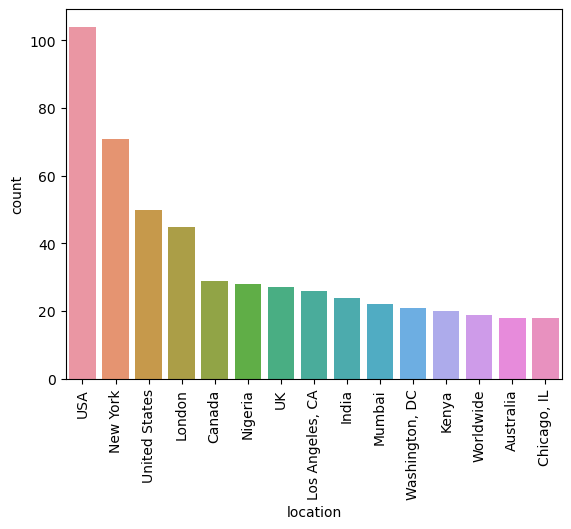

In [161]:
sns.countplot(x=train["location"],order=train.location.value_counts().iloc[:15].index)
plt.xticks(rotation=90)

In [162]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,NaN,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [163]:
text_to_train=train.text[3]

In [164]:
def location(cols):
    location=cols[0]
    text=cols[1]
    if pd.notna(location):
        return location
    text=nlp(text)
    for word in text.ents :
        if word.label_ in ["GPE","LOC"]:
            return word.text
    return "Others"

In [165]:
train["location"]=train[["location","text"]].apply(location,axis=1)

In [166]:
def cleanLocation(x):
    if x == 'Others':
        return 'Others'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    else:
        return x

In [167]:
train["location"]=train["location"].apply(cleanLocation)

In [168]:
train.head()

,id,keyword,location,text,target
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1


In [169]:
location=train.location.unique().tolist()

In [170]:
len(location)

3026

In [171]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [172]:
# def extractInformation(text):
#     hashWords=[]
#     hash_seq="#(\w+)"
#     hash_count=0
#     text=re.findall(hash_seq,text)
#     for word in text:
#         hash_count+=1  
#         hashWords.append(str(word))
#     return hashWords
# hashtagWords=extractInformation("Hi this is a beatuiful morning #hot #sunny")

In [173]:
def extractInformation(text):
    hash_seq="#(\w+)"
    text=re.findall(hash_seq,text)
    if text==[]:
        return []
    return text
hashtagWords=extractInformation("Hi this is a beatuiful morning hot sunny")

In [174]:
def hashMod(text):
    words=[]
    for word in text:
        if word in keyword:
            words.append(word)
    if words is not []:
        return words
    if text==[]:
        return("None")
    if words is []:
        return text
    

In [175]:
train["HashtagWords"]=train["text"].apply(extractInformation)
train["HashtagWords"]=train["HashtagWords"].apply(hashMod)
train["HashTagSum"]=train["HashtagWords"].apply(lambda x:len(x))

In [176]:
def joinKeywords(text):
    return " ".join(text)
train["HashtagWords"]=train["HashtagWords"].apply(joinKeywords)

In [177]:
# x=train[train["target"]==1]["text"].apply(len)
# y=train[train["target"]==0]["text"].apply(len)
# print("Average length of real tweets are ",np.average(x),"\n Average length of fake tweets are ",np.average(y))

In [178]:
def mentionSearch(text):
    pattern="@(\w+)"
    text=re.findall(pattern,text)
    if text==[]:
        return ("None")
    return " ".join(text)
train["mention"]=train["text"].apply(mentionSearch)
# train["mention"].value_counts()

In [179]:
def sentimentInput(text):
    return sentiment.polarity_scores(text)["neg"]
train["SentimentScore"]=train["text"].apply(sentimentInput)

In [180]:
# text="You should less drink water and kill more people and stab them"
# sentimentInput(text)
# sentimentZero=train[train["SentimentScore"]==0]
# sentimentZero['target'].value_counts()
# sentimentNotZero=train[train["SentimentScore"]!=0]
# sentimentNotZero["target"].value_counts()
# sentimentGreaterThan5=(train["SentimentScore"]>0.25).sum()

In [181]:
train["HashtagWords"]=train["HashtagWords"].replace("","None")

In [182]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000


In [183]:
train["HashtagWords"].unique()

array(['earthquake', 'None', 'wildfires', 'flood disaster', 'flooding',
       'aftershock', 'accident', 'ambulance', 'apocalypse', 'armageddon',
       'bioterrorism', 'bombed', 'wildfire', 'casualties', 'catastrophe',
       'danger', 'dead', 'tragedy crash', 'floods', 'deluge',
       'demolished', 'survived', 'destruction', 'disaster', 'displaced',
       'drought', 'bomb', 'Earthquake', 'fire emergency rescue sirens',
       'evacuate', 'evacuation', 'fire', 'floods flooding', 'hailstorm',
       'hail hailstorm', 'hostages terrorism', 'terrorism', 'hurricane',
       'sinkhole landslide avalanche', 'landslide', 'lava', 'military',
       'disaster mudslide', 'mudslide', 'refugees', 'obliteration',
       'police', 'emergency', 'rainstorm landslide', 'drought wildfires',
       'rescued', 'seismic', 'sinkhole', 'sinking', 'storm', 'thunder',
       'Thunderstorm', 'thunder lightning thunderstorm', 'trauma',
       'survivors', 'traumatised', 'tsunami', 'whirlwind', 'fires',
      

In [184]:
def urlSearch(text):
    pattern=r"https?://t\.co/\S+"
    urls=re.findall(pattern,text)
    if urls:
        return " ".join(urls)
    else:
        return False
    

In [185]:
sample=urlSearch("Hi follow this url https://t.co/7MLMsUzV1Z")
sample

'https://t.co/7MLMsUzV1Z'

In [186]:
train["UrlCount"]=train["text"].apply(urlSearch)

In [187]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount
5470,7804,quarantine,"Joshua Tree, CA",Reddit Will Now Quarantine Offensive Content h...,1,None,0,None,0.300,http://t.co/WosYPVQUFI http://t.co/XW8SDS1Tjp
553,802,battle,Others,It's baaaack! Petersen's Bowhunting Battle of...,0,None,0,None,0.120,http://t.co/FJ73gDvg2n
545,794,avalanche,Others,Chevrolet : Avalanche LT 2011 lt used 5.3 l v ...,1,None,0,None,0.000,http://t.co/OBkY8Pc89H http://t.co/dXIRnTdSrd
4598,6540,injury,Others,JOBOOZOSO: USAT usatoday_nfl Michael Floyd's h...,0,None,0,None,0.165,http://t.co/DGkmUEoAxZ
7321,10481,wild%20fires,Others,Wild land fires.. Here I come. ??????,1,None,0,None,0.000,False
6588,9434,survivors,Upstairs.,People with netflix there's a really good docu...,0,None,0,None,0.150,False
5299,7569,outbreak,Los Angeles,Families to sue over Legionnaires: More than 4...,1,None,0,None,0.242,http://t.co/oJyW7jkUH5
571,826,battle,Australia,#LonePine remembered around Australia as 'desc...,0,None,0,666canberra,0.000,http://t.co/T4fvVnRPc5 http://t.co/0zZnbVFUVO
4112,5843,hailstorm,far away,Calgary news weather and traffic for August 5 ...,0,None,0,None,0.000,http://t.co/qBdRYXSGlC http://t.co/VZOd7qFFlv
977,1414,body%20bag,Paignton,å_? New Ladies Shoulder Tote #Handbag Faux Lea...,0,None,0,None,0.000,http://t.co/zujwUiomb3 http://t.co/YklTFj1FnC


In [188]:
def clean_text(text):
    pattern1=r"https?://t\.co/\S+"
    pattern2=r"\d+"
    pattern3=r"@\w+"
    text=re.sub(pattern1,"",text)
    text=re.sub(pattern2,"",text)
    text=re.sub(pattern3,"",text)
    return text.strip()
clean_text("Hi this si a https://t.co/7MLMsUzV1Z 8980098 @return")

'Hi this si a'

In [189]:
train["cleaned_text"]=train["text"].apply(clean_text)

In [190]:
train.head()

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text
0,1,earthquake,Others,Our Deeds are the Reason of this #earthquake M...,1,earthquake,1,None,0.000,False,Our Deeds are the Reason of this #earthquake M...
1,4,fire,Canada,Forest fire near La Ronge Sask. Canada,1,None,0,None,0.286,False,Forest fire near La Ronge Sask. Canada
2,5,evacuation,Others,All residents asked to 'shelter in place' are ...,1,None,0,None,0.095,False,All residents asked to 'shelter in place' are ...
3,6,wildfires,California,"13,000 people receive #wildfires evacuation or...",1,wildfires,1,None,0.000,False,", people receive #wildfires evacuation orders ..."
4,7,smoke,Alaska,Just got sent this photo from Ruby #Alaska as ...,1,wildfires,1,None,0.000,False,Just got sent this photo from Ruby #Alaska as ...


In [191]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

def grams(text):
    n=3
    text=word_tokenize(text)
    ngramsText=ngrams(text,n)
    return [" ".join(words) for words in ngramsText]

In [192]:
train["Trigrams"]=train["text"].apply(grams)

In [193]:
train.sample(5)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams
3394,4858,evacuation,"Brisbane, Queensland",Evacuation drill at work. The fire doors would...,0,None,0,None,0.238,False,Evacuation drill at work. The fire doors would...,"[Evacuation drill at, drill at work, at work ...."
5932,8472,screamed,USA,Vacation update: my great aunt just killed a s...,1,None,0,None,0.341,False,Vacation update: my great aunt just killed a s...,"[Vacation update :, update : my, : my great, m..."
7352,10524,wildfire,Others,For those impacted by the #CalWildfires here a...,1,None,0,None,0.000,http://t.co/wwxbGuBww5,For those impacted by the #CalWildfires here a...,"[For those impacted, those impacted by, impact..."
719,1040,bleeding,IN,you can stab me in the back but I promise you'...,1,None,0,None,0.138,False,you can stab me in the back but I promise you'...,"[you can stab, can stab me, stab me in, me in ..."
2938,4221,drowned,IG: AyshBanaysh,Sometimes logic gets drowned out in emotion bu...,0,None,0,None,0.159,False,Sometimes logic gets drowned out in emotion bu...,"[Sometimes logic gets, logic gets drowned, get..."


In [194]:
train["Trigrams"]=train["Trigrams"]

In [195]:
text=train["Trigrams"][0]
text

['Our Deeds are',
 'Deeds are the',
 'are the Reason',
 'the Reason of',
 'Reason of this',
 'of this #',
 'this # earthquake',
 '# earthquake May',
 'earthquake May ALLAH',
 'May ALLAH Forgive',
 'ALLAH Forgive us',
 'Forgive us all']

In [196]:
def vectorize(text):
    vectors=[]
    for trigram in text:
        trigram=nlp(trigram)
        vectors.append(trigram.vector)  
    return vectors      

In [197]:
train.corr()["target"].drop("target").sort_values()

id                0.060781
HashTagSum        0.075032
SentimentScore    0.124187
Name: target, dtype: float64

In [198]:
train.sample(10)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams
6847,9813,trauma,"Detroit, MI",#NissanNews : Trauma Alert and 1 Child Among 6...,1,None,0,None,0.249,http://t.co/9dWyJqvFY4,#NissanNews : Trauma Alert and Child Among H...,"[# NissanNews :, NissanNews : Trauma, : Trauma..."
1449,2089,casualty,"Boulder, CO",RT @GreenHarvard: Documenting climate change's...,1,None,0,GreenHarvard GreenHarvard,0.254,http://t.co/4q4zd7oU34,RT : Documenting climate change's first major ...,"[RT @ GreenHarvard, @ GreenHarvard :, GreenHar..."
6201,8851,smoke,Others,Smoke with me baby and lay with me baby and la...,0,None,0,None,0.000,False,Smoke with me baby and lay with me baby and la...,"[Smoke with me, with me baby, me baby and, bab..."
1700,2455,collided,Others,My 2 fav worlds have collided! Thanks to @lenn...,0,None,0,lennonparham Jessica_StClair GilmoreGuysShow,0.000,False,My fav worlds have collided! Thanks to I fo...,"[My 2 fav, 2 fav worlds, fav worlds have, worl..."
3098,4448,electrocuted,Others,When I was cooking earlier I got electrocuted ...,0,None,0,None,0.000,False,When I was cooking earlier I got electrocuted ...,"[When I was, I was cooking, was cooking earlie..."
5535,7895,radiation%20emergency,USA,http://t.co/X5XUMtoEkE Nuclear Emergency Curre...,0,None,0,None,0.245,http://t.co/X5XUMtoEkE,Nuclear Emergency Current USA radiation levels...,"[http : //t.co/X5XUMtoEkE, : //t.co/X5XUMtoEkE..."
3857,5487,flames,manaus,watching it go up in flames,1,None,0,None,0.000,False,watching it go up in flames,"[watching it go, it go up, go up in, up in fla..."
790,1145,blight,Baton Rouge,Carl Everest Rob Cobes Whitt Blight Frost Leo ...,0,None,0,None,0.167,False,Carl Everest Rob Cobes Whitt Blight Frost Leo ...,"[Carl Everest Rob, Everest Rob Cobes, Rob Cobe..."
7569,10819,wrecked,"Livingston, MT",@marynmck That's beyond adorable. I hope it wo...,0,None,0,marynmck,0.000,False,That's beyond adorable. I hope it won't be wre...,"[@ marynmck That, marynmck That 's, That 's be..."
60,85,ablaze,Others,Revel in yours wmv videos by means of mac fare...,0,None,0,None,0.000,False,Revel in yours wmv videos by means of mac fare...,"[Revel in yours, in yours wmv, yours wmv video..."


In [199]:
text="hello once again i am here to make work happen and once again i would like to thank you al"
def tags(text):
    text=nlp(text)
    for word in text:
        print(word.text ," ",spacy.explain(word.tag_))

In [200]:
def pos(text):
    text=nlp(text)
    oov=0
    noun=0
    adj=0
    adv=0
    verb=0
    punct=0
    det=0
    part=0
    for word in text:
        if word.pos_ == "NOUN":
            noun+=1
        elif word.is_oov:
            oov+=1
        elif word.pos_ == "ADJ":
            adj+=1
        elif word.pos_ == "ADV":
            adv+=1
        elif word.pos == "VERB":
            verb+=1
        elif word.pos_ =="PUNCT":
            punct+=1
        elif word.pos_ =="DET":
            det+=1
        elif word.pos_ =="PART":
            part+=1
    return oov,noun,adj,adv,verb,punct,det,part

In [201]:
oov,noun,adj,adv,verb,punct,det,part=pos(text)

In [202]:
train[["oov", "noun", "adj", "adv", "verb", "punct", "det", "part"]]=train["text"].apply(pos).apply(pd.Series)

In [203]:
train.sample(2)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams,oov,noun,adj,adv,verb,punct,det,part
5248,7504,oil%20spill,Los Angeles,Refugio oil spill may have been costlier bigge...,1,None,0,None,0.000,http://t.co/Rqu5Ub8PLF,Refugio oil spill may have been costlier bigge...,"[Refugio oil spill, oil spill may, spill may h...",0,4,1,1,0,0,0,0
1614,2332,collapse,Fakefams,Correction: Tent Collapse Story http://t.co/S7...,1,None,0,None,0.444,http://t.co/S7VYGeNJuv,Correction: Tent Collapse Story,"[Correction : Tent, : Tent Collapse, Tent Coll...",1,1,0,0,0,1,0,0


In [204]:
train["UrlCount"]=train["UrlCount"].apply(lambda x:1 if x!=False else 0)

In [205]:
train.sample(6)

,id,keyword,location,text,target,HashtagWords,HashTagSum,mention,SentimentScore,UrlCount,cleaned_text,Trigrams,oov,noun,adj,adv,verb,punct,det,part
1268,1827,burned,Nxgerxa,Burned my popcorn??,0,None,0,None,0.000,0,Burned my popcorn??,"[Burned my popcorn, my popcorn ?, popcorn ? ?]",0,1,0,0,0,2,0,0
1310,1892,burning,"Caracas, Venezuela.",We will be burning up like neon lights??????,1,None,0,None,0.000,0,We will be burning up like neon lights??????,"[We will be, will be burning, be burning up, b...",0,2,0,0,0,6,0,0
6730,9644,thunderstorm,Oklahoma,OUN continues Severe Thunderstorm Warning for ...,1,None,0,None,0.312,1,OUN continues Severe Thunderstorm Warning for ...,"[OUN continues Severe, continues Severe Thunde...",0,3,0,0,0,0,0,0
263,380,annihilation,"Phoenix, AZ",Hey #AZ: Sign this petition to save the #WildH...,0,None,0,RollingStones,0.000,1,Hey #AZ: Sign this petition to save the #WildH...,"[Hey # AZ, # AZ :, AZ : Sign, : Sign this, Sig...",3,5,1,0,0,5,4,1
5,8,fire,Lake County,#RockyFire Update => California Hwy. 20 closed...,1,wildfires,1,None,0.130,0,#RockyFire Update => California Hwy. closed i...,"[# RockyFire Update, RockyFire Update =, Updat...",2,5,0,0,0,1,1,0
2296,3295,demolish,KOLKATA,@Jolly_Jinu you said they are terrorist becaus...,0,None,0,Jolly_Jinu,0.274,0,you said they are terrorist because of #Babri ...,"[@ Jolly_Jinu you, Jolly_Jinu you said, you sa...",1,3,3,1,0,2,0,1


In [206]:
train.dtypes

id                  int64
keyword            object
location           object
text               object
target              int64
HashtagWords       object
HashTagSum          int64
mention            object
SentimentScore    float64
UrlCount            int64
cleaned_text       object
Trigrams           object
oov                 int64
noun                int64
adj                 int64
adv                 int64
verb                int64
punct               int64
det                 int64
part                int64
dtype: object

In [207]:
# def clean_signs(text):
#     text=re.sub(r"[^a-zA-Z\s]","",text)
# train["keyword"]=train["keyword"].astype("str").apply(clean_signs)

<AxesSubplot:xlabel='UrlCount', ylabel='count'>

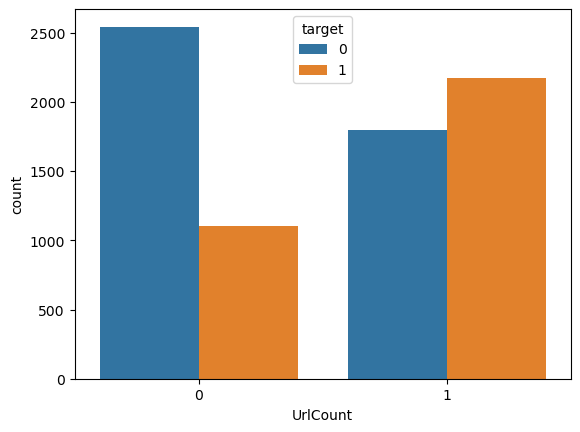

In [208]:
sns.countplot(x="UrlCount",data=train,hue="target")

<AxesSubplot:xlabel='HashTagSum', ylabel='count'>

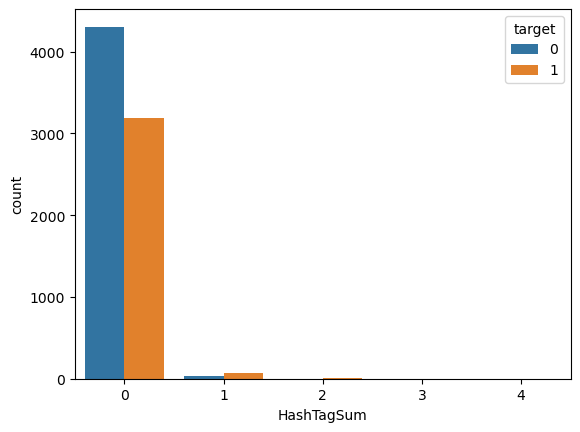

In [210]:
sns.countplot(x="HashTagSum",data=train,hue="target")

In [209]:
from sklearn.feature_extraction.text import CountVectorizer
